House Pricing Prediction - Part Two | Outliers Extraction Baseline Model | Feature Selection using Shapley Values 

# Phase One: With/Without Outliers Analysis, Getting Baseline Model

Loading Datasets

In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
import lightgbm as lgbm

import numpy as np

import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import shap


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

path = "./data/outlier-exclusion/"
with open(path + "dataset-w-outliers-new-ord-enc.json", 'r') as f:
    data_w_outliers = json.load(f)

with open(path + "dataset-wo-outliers.json", 'r') as f:
    data_wo_outliers = json.load(f)

with open(path + "dataset-wo-outliers_2.json", 'r') as f:
    data_wo_outliers_2 = json.load(f)

df_w_outliers = pd.DataFrame.from_dict(data_w_outliers,orient="columns")
df_wo_outliers = pd.DataFrame.from_dict(data_wo_outliers,orient="columns")
df_wo_outliers_2 = pd.DataFrame.from_dict(data_wo_outliers_2,orient="columns")

Split dataset into training-validation set

In [3]:
X_w_outliers = df_w_outliers.drop(["SalePrice"],axis = 1)
y_w_outliers = df_w_outliers["SalePrice"]

X_wo_outliers = df_wo_outliers.drop(["SalePrice"],axis = 1)
y_wo_outliers = df_wo_outliers["SalePrice"]

X_wo_outliers_2 = df_wo_outliers_2.drop(["SalePrice"],axis = 1)
y_wo_outliers_2 = df_wo_outliers_2["SalePrice"]


test_size = 0.25
random_state = 43

X_train_w,X_valid_w,y_train_w, y_valid_w = train_test_split(X_w_outliers.to_numpy(),y_w_outliers.to_numpy(),test_size=test_size,random_state=random_state)
X_train_wo,X_valid_wo,y_train_wo, y_valid_wo = train_test_split(X_wo_outliers.to_numpy(),y_wo_outliers.to_numpy(),test_size=test_size,random_state=random_state)
X_train_wo_2,X_valid_wo_2,y_train_wo_2, y_valid_wo_2 = train_test_split(X_wo_outliers_2.to_numpy(),y_wo_outliers_2.to_numpy(),test_size=test_size,random_state=random_state)

y_train_w = y_train_w.reshape(-1,1)
y_valid_w = y_valid_w.reshape(-1,1)
y_train_wo = y_train_wo.reshape(-1,1)
y_valid_wo = y_valid_wo.reshape(-1,1)
y_train_wo_2 = y_train_wo_2.reshape(-1,1)
y_valid_wo_2 = y_valid_wo_2.reshape(-1,1)


In [4]:
#Normalize train dataset with outliers

scaler_X_train_w = StandardScaler().fit(X_train_w)
scaler_y_train_w = StandardScaler().fit(y_train_w)

X_train_w_norm = scaler_X_train_w.transform(X_train_w)
y_train_w_norm = scaler_y_train_w.transform(y_train_w)

#normalize validation dataset with outliers, mean and stddev from training distribution

mean_X_train_w = scaler_X_train_w.mean_.reshape(1,-1).repeat(X_valid_w.shape[0],axis=0)
mean_y_train_w = scaler_y_train_w.mean_.reshape(1,-1).repeat(y_valid_w.shape[0],axis=0)

X_valid_w_norm = (X_valid_w - mean_X_train_w) / scaler_X_train_w.scale_
y_valid_w_norm = (y_valid_w - mean_y_train_w) / scaler_y_train_w.scale_

In [5]:
#Normalize train dataset without outliers

scaler_X_train_wo = StandardScaler().fit(X_train_wo)
scaler_y_train_wo = StandardScaler().fit(y_train_wo)

X_train_wo_norm = scaler_X_train_wo.transform(X_train_wo)
y_train_wo_norm = scaler_y_train_wo.transform(y_train_wo)

#normalize validation dataset without outliers, mean and stddev from training distribution

mean_X_train_wo = scaler_X_train_wo.mean_.reshape(1,-1).repeat(X_valid_wo.shape[0],axis=0)
mean_y_train_wo = scaler_y_train_wo.mean_.reshape(1,-1).repeat(y_valid_wo.shape[0],axis=0)

X_valid_wo_norm = (X_valid_wo - mean_X_train_wo) / scaler_X_train_wo.scale_
y_valid_wo_norm = (y_valid_wo - mean_y_train_wo) / scaler_y_train_wo.scale_

In [6]:
#Normalize train dataset without outliers 2

scaler_X_train_wo_2 = StandardScaler().fit(X_train_wo_2)
scaler_y_train_wo_2 = StandardScaler().fit(y_train_wo_2)

X_train_wo_norm_2 = scaler_X_train_wo_2.transform(X_train_wo_2)
y_train_wo_norm_2 = scaler_y_train_wo_2.transform(y_train_wo_2)

#normalize validation dataset without outliers 2, mean and stddev from training distribution

mean_X_train_wo_2 = scaler_X_train_wo_2.mean_.reshape(1,-1).repeat(X_valid_wo_2.shape[0],axis=0)
mean_y_train_wo_2 = scaler_y_train_wo_2.mean_.reshape(1,-1).repeat(y_valid_wo_2.shape[0],axis=0)

X_valid_wo_norm_2 = (X_valid_wo_2 - mean_X_train_wo_2) / scaler_X_train_wo_2.scale_
y_valid_wo_norm_2 = (y_valid_wo_2 - mean_y_train_wo_2) / scaler_y_train_wo_2.scale_

In [7]:
#Normalize train dataset without outliers y = ln(saleprice)

X_train_wo_norm_3 = scaler_X_train_wo.transform(X_train_wo)
y_train_wo_norm_3 = np.log(y_train_wo)

#normalize validation dataset without outliers y= ln(saleprice), mean and stddev from training distribution

X_valid_wo_norm_3 = (X_valid_wo - mean_X_train_wo) / scaler_X_train_wo.scale_
y_valid_wo_norm_3 = np.log(y_valid_wo)

Training baselines models

In [4]:
# training baselines models dataset with outliers - no normalization

n_estimators = 100
loss = "squared_error"
learning_rate = 0.1
max_depth = 4
random_state = 43
verbose = 0
alpha = 1.5
kernel = "poly"
degree = 4

tree_estimator = DecisionTreeRegressor(criterion=loss,max_depth=max_depth,random_state=random_state)

models = [
    Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('ridge', Ridge(alpha=alpha, random_state=random_state))]),
                  SVR(kernel=kernel,degree=degree, C= alpha),
    GradientBoostingRegressor(n_estimators=n_estimators, loss=loss, learning_rate=learning_rate, max_depth=max_depth,random_state=random_state,
                              verbose=verbose),
    RandomForestRegressor(n_estimators=n_estimators,criterion=loss,max_depth=max_depth,random_state=random_state,
                          verbose=verbose),
    AdaBoostRegressor(estimator=tree_estimator,n_estimators=n_estimators,learning_rate=learning_rate,loss="square",random_state=random_state),
    xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
    lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1)
]

for model in models:
    #train model with training set
    model.fit(X_train_w,np.log(y_train_w))

    #predict output using validation set
    pred = model.predict(X_valid_w)

    #find MSE score 
    mse_score = mean_squared_error(np.log(y_valid_w),pred)
    print(f"Model : {model.__class__}, MSE score in validation set : {mse_score}")



c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


Model : <class 'sklearn.pipeline.Pipeline'>, MSE score in validation set : 14856.703674742832


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.svm._classes.SVR'>, MSE score in validation set : 1229.5965094843439


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Model : <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, MSE score in validation set : 0.02576408336431433


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model : <class 'sklearn.ensemble._forest.RandomForestRegressor'>, MSE score in validation set : 0.036665072889249806


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, MSE score in validation set : 0.03398148225667936


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:40:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'xgboost.sklearn.XGBRegressor'>, MSE score in validation set : 0.024365641899188974
Model : <class 'lightgbm.sklearn.LGBMRegressor'>, MSE score in validation set : 0.025073508745031038


In [9]:
# training baselines models dataset with outliers - normalization

tree_estimator = DecisionTreeRegressor(criterion=loss,max_depth=max_depth,random_state=random_state)

models = [
    Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('ridge', Ridge(alpha=alpha, random_state=random_state))]),
                  SVR(kernel=kernel,degree=degree, C= alpha),
    GradientBoostingRegressor(n_estimators=n_estimators, loss=loss, learning_rate=learning_rate, max_depth=max_depth,random_state=random_state,
                              verbose=verbose),
    RandomForestRegressor(n_estimators=n_estimators,criterion=loss,max_depth=max_depth,random_state=random_state,
                          verbose=verbose),
    AdaBoostRegressor(estimator=tree_estimator,n_estimators=n_estimators,learning_rate=learning_rate,loss="square",random_state=random_state),
    xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
    lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1)
]

for model in models:
    #train model with training set
    model.fit(X_train_w_norm,y_train_w_norm)

    #predict output using validation set
    pred = model.predict(X_valid_w_norm)

    #find MSE score 
    mse_score = mean_squared_error(y_valid_w_norm,pred)
    print(f"Model : {model.__class__}, MSE score in validation set : {mse_score}")

Model : <class 'sklearn.pipeline.Pipeline'>, MSE score in validation set : 36.74097135023233
Model : <class 'sklearn.svm._classes.SVR'>, MSE score in validation set : 19.973663458209565


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Model : <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, MSE score in validation set : 0.3051895522075681


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model : <class 'sklearn.ensemble._forest.RandomForestRegressor'>, MSE score in validation set : 0.2801022793012026


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, MSE score in validation set : 0.3190318700835608
Model : <class 'xgboost.sklearn.XGBRegressor'>, MSE score in validation set : 0.2691360977441718
Model : <class 'lightgbm.sklearn.LGBMRegressor'>, MSE score in validation set : 0.2240832902927248


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# training baselines models dataset without outliers - normalization

tree_estimator = DecisionTreeRegressor(criterion=loss,max_depth=max_depth,random_state=random_state)

models = [
    Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('ridge', Ridge(alpha=alpha, random_state=random_state))]),
                  SVR(kernel=kernel,degree=degree, C= alpha),
    GradientBoostingRegressor(n_estimators=n_estimators, loss=loss, learning_rate=learning_rate, max_depth=max_depth,random_state=random_state,
                              verbose=verbose),
    RandomForestRegressor(n_estimators=n_estimators,criterion=loss,max_depth=max_depth,random_state=random_state,
                          verbose=verbose),
    AdaBoostRegressor(estimator=tree_estimator,n_estimators=n_estimators,learning_rate=learning_rate,loss="square",random_state=random_state),
    xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
    lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1)
]

for model in models:
    #train model with training set
    model.fit(X_train_wo_norm,y_train_wo_norm)

    #predict output using validation set
    pred = model.predict(X_valid_wo_norm)

    #find MSE score 
    mse_score = mean_squared_error(y_valid_wo_norm,pred)
    print(f"Model : {model.__class__}, MSE score in validation set : {mse_score}")

Model : <class 'sklearn.pipeline.Pipeline'>, MSE score in validation set : 21.31275748978485
Model : <class 'sklearn.svm._classes.SVR'>, MSE score in validation set : 1.9371900900840935


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Model : <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, MSE score in validation set : 0.0904700090552259


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model : <class 'sklearn.ensemble._forest.RandomForestRegressor'>, MSE score in validation set : 0.1641017190601578


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, MSE score in validation set : 0.13698505338858222
Model : <class 'xgboost.sklearn.XGBRegressor'>, MSE score in validation set : 0.081197656468555
Model : <class 'lightgbm.sklearn.LGBMRegressor'>, MSE score in validation set : 0.07518591425499802


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# training baselines models dataset without outliers 2 - normalization

tree_estimator = DecisionTreeRegressor(criterion=loss,max_depth=max_depth,random_state=random_state)

models = [
    Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('ridge', Ridge(alpha=alpha, random_state=random_state))]),
                  SVR(kernel=kernel,degree=degree, C= alpha),
    GradientBoostingRegressor(n_estimators=n_estimators, loss=loss, learning_rate=learning_rate, max_depth=max_depth,random_state=random_state,
                              verbose=verbose),
    RandomForestRegressor(n_estimators=n_estimators,criterion=loss,max_depth=max_depth,random_state=random_state,
                          verbose=verbose),
    AdaBoostRegressor(estimator=tree_estimator,n_estimators=n_estimators,learning_rate=learning_rate,loss="square",random_state=random_state),
    xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
    lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1)
]

for model in models:
    #train model with training set
    model.fit(X_train_wo_norm_2,y_train_wo_norm_2)

    #predict output using validation set
    pred = model.predict(X_valid_wo_norm_2)

    #find MSE score 
    mse_score = mean_squared_error(y_valid_wo_norm_2,pred)
    print(f"Model : {model.__class__}, MSE score in validation set : {mse_score}")

Model : <class 'sklearn.pipeline.Pipeline'>, MSE score in validation set : 0.2822254926032053
Model : <class 'sklearn.svm._classes.SVR'>, MSE score in validation set : 0.39731539668843


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Model : <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, MSE score in validation set : 0.09958083176921609


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model : <class 'sklearn.ensemble._forest.RandomForestRegressor'>, MSE score in validation set : 0.1652514209844309


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, MSE score in validation set : 0.14847094294127358
Model : <class 'xgboost.sklearn.XGBRegressor'>, MSE score in validation set : 0.08589763681684627
Model : <class 'lightgbm.sklearn.LGBMRegressor'>, MSE score in validation set : 0.09145188332363986


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
# training baselines models dataset without outliers - norm - ln(saleprice)


tree_estimator = DecisionTreeRegressor(criterion=loss,max_depth=max_depth,random_state=random_state)

models = [
    Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('ridge', Ridge(alpha=alpha, random_state=random_state))]),
                  SVR(kernel=kernel,degree=degree, C= alpha),
    GradientBoostingRegressor(n_estimators=n_estimators, loss=loss, learning_rate=learning_rate, max_depth=max_depth,random_state=random_state,
                              verbose=verbose),
    RandomForestRegressor(n_estimators=n_estimators,criterion=loss,max_depth=max_depth,random_state=random_state,
                          verbose=verbose),
    AdaBoostRegressor(estimator=tree_estimator,n_estimators=n_estimators,learning_rate=learning_rate,loss="square",random_state=random_state),
    xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
    lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1)
]

for model in models:
    #train model with training set
    model.fit(X_train_wo_norm_3,y_train_wo_norm_3)

    #predict output using validation set
    pred = model.predict(X_valid_wo_norm_3)

    #find MSE score 
    mse_score = mean_squared_error(y_valid_wo_norm_3,pred)
    print(f"Model : {model.__class__}, MSE score in validation set : {mse_score}")


Model : <class 'sklearn.pipeline.Pipeline'>, MSE score in validation set : 4.352865403422825
Model : <class 'sklearn.svm._classes.SVR'>, MSE score in validation set : 0.2596376909123574


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\ensemble\_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Model : <class 'sklearn.ensemble._gb.GradientBoostingRegressor'>, MSE score in validation set : 0.01709189829050655


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Model : <class 'sklearn.ensemble._forest.RandomForestRegressor'>, MSE score in validation set : 0.032666078634784455


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model : <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>, MSE score in validation set : 0.02541412123852059
Model : <class 'xgboost.sklearn.XGBRegressor'>, MSE score in validation set : 0.015770162427662264
Model : <class 'lightgbm.sklearn.LGBMRegressor'>, MSE score in validation set : 0.016055920473476697


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:36:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<table>
    <thead>
        <tr>
            <th></th>
            <th colspan = 4><center>Metric: Mean Squared Error (MSE) </center></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td ><center>ML Model</center></td>
            <td ><center>Dataset with Outliers (Norm)</center></td>
            <td><center>Dataset without Outliers (Norm)</center></td>
            <td><center>Dataset without Outliers 2 (Norm)</center></td>
            <td><center>Dataset without Outliers (Norm & Ln(SalePrice))</center></td>
        </tr>
        <tr>
            <td><center>Ridge with L2 Reg</center></td>
            <td><center>36.74</center></td>
            <td><center>21.312</center></td>
            <td><center>0.282</center></td>
            <td><center>4.352</center></td>
        </tr>
        <tr>
            <td><center>SVM with L2 Reg</center></td>
            <td><center> 19.973</center></td>
            <td><center>1.937</center></td>
            <td><center>0.397</center></td>
            <td><center>0.259</center></td>
        </tr>
        <tr>
            <td><center>Gradient Boosting</center></td>
            <td><center> 0.305</center></td>
            <td><center>0.090</center></td>
            <td><center>0.099</center></td>
            <td><center>0.017</center></td>
        </tr>
        <tr>
            <td><center>Random Forest</center></td>
            <td><center>0.28</center></td>
            <td><center>0.164</center></td>
            <td><center>0.165</center></td>
            <td><center>0.032</center></td>
        </tr>
        <tr>
            <td><center>AdaBoost</center></td>
            <td><center>0.319</center></td>
            <td><center>0.136</center></td>
            <td><center>0.148</center></td>
            <td><center>0.025</center></td>
        </tr>
        <tr>
            <td><center>XGB</center></td>
            <td><center><span style="text-decoration: underline;">0.269</span></center></td>
            <td><center><span style="text-decoration: underline;">0.081</span></center></td>
            <td><center><strong>0.085</strong></center></td>
            <td><center><strong>0.01577</strong></center></td>
        </tr>
        <tr>
            <td><center> LightGBM</center></td>
            <td><center><strong>0.224</strong></center></td>
            <td><center><strong>0.075</strong></center></td>
            <td><center><span style="text-decoration: underline;">0.091</span></center></td>
            <td><center><span style="text-decoration: underline;">0.01605</span></center></td>
        </tr>
    </tbody>
</table>

Conclusion #1: Evidently, LightGBM and XGB obtained the lowest MSE scores for the dataset with and without outliers.

Conclusion #2: Looking at the results from the middle column in the table (dataset without outliers) we can conclude that erasing outliers in features: LotFrontage and MasVnrArea and filling missing values with the mean of these distributions produced better performance when compared with the dataset with the outliers. 

Conclusion #3: Natural log of SalePrice yields better performance than applying standard normalization.

For future steps we are going to leverage the Dataset without Outliers & Ln(SalePrice) and will benchmark models with gradient boosting algorithms.

# Phase Two: Feature Selection 

The target Dataset with no outliers includes 75 features and 1272 rows, we are intrigued to find out if some of these features are not providing a value to the model's prediction. Furthermore, this section will encompass two main approaches: Correlation Analysis and Shapley values, to select a subset of features that provides enough information to make a good prediction in the validation set, as well as to generalize better.

3 datasets per approach will be extracted and benchmarked to find if our feature selection does improve the best trained model from phase one.

## Correlation analysis approach

The methodology for this step will be to compute the correlation index between the features with our target output, in this case, SalePrice. We are setting a correlation threshold value of +- 0.1 to denote that the feature is somewhat correlated with the output. 

In [13]:
saleprice_corr_features = df_wo_outliers.corr().loc["SalePrice"]

In [14]:
filtered_saleprice_corr_features_1 = saleprice_corr_features[(np.abs(saleprice_corr_features.values) >= 0.1)].drop(labels=["SalePrice"])

In [15]:
filtered_saleprice_corr_features_1.count()

np.int64(52)

<Axes: >

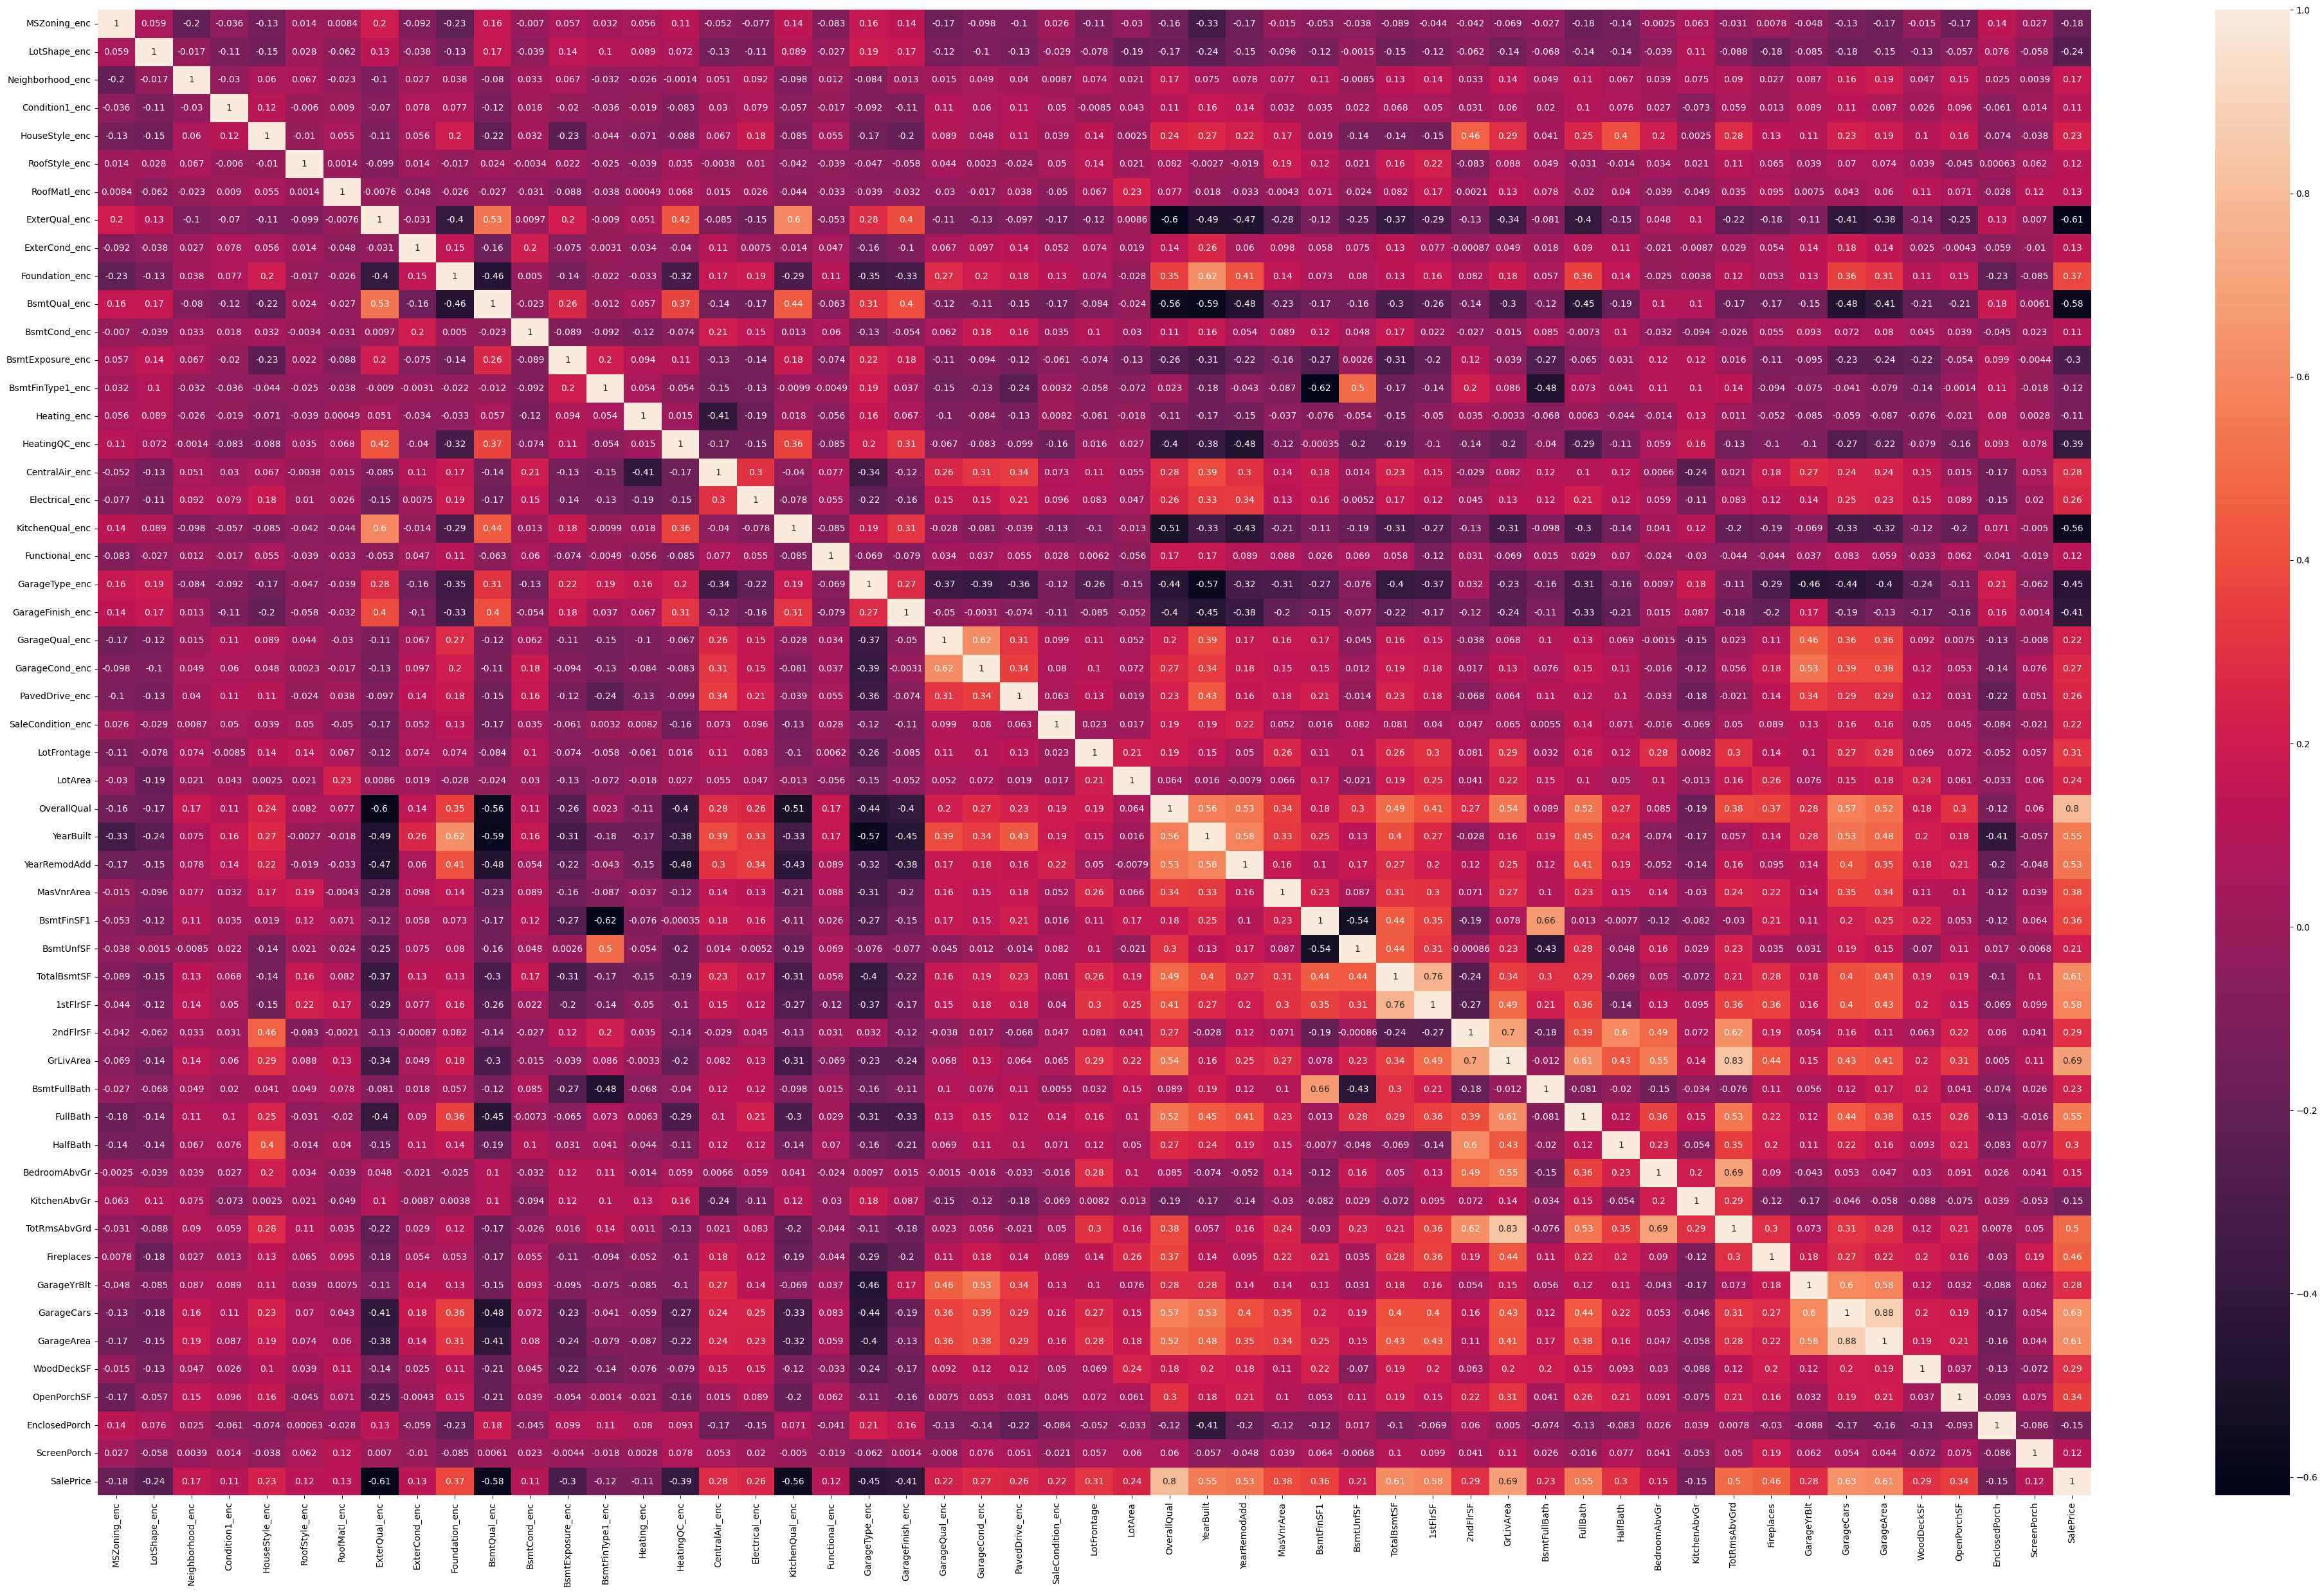

In [16]:
fig,ax = plt.subplots(1,1,figsize= (50,30))

sns.heatmap(data=pd.concat([df_wo_outliers[filtered_saleprice_corr_features_1.index], df_wo_outliers["SalePrice"]],axis=1).corr(),annot=True,
            ax = ax)

From previous plot and with the previous defined threshold, we obtained 52 possibly correlated features with output. Selecting relevant features from the visualization is a nuissance task, thus we opted to set 4 partition threshold points, these points will produce 4 feature subsets as follows:

1. Features with correlation value >= 0.15
2. Features with correlation value >= 0.25
3. Features with correlation value >= 0.35
4. Features with correlation value >= 0.55

These 4 subsets will constitute the benchmarked correlation feature selection dataframes and will be put on to test in further steps of this phase.


In [17]:
corr_1_df_wo_outliers = df_wo_outliers.copy()
corr_2_df_wo_outliers = df_wo_outliers.copy()
corr_3_df_wo_outliers = df_wo_outliers.copy()
corr_4_df_wo_outliers = df_wo_outliers.copy()

corr_1_df_wo_outliers = corr_1_df_wo_outliers[saleprice_corr_features[(np.abs(saleprice_corr_features.values) >= 0.15)].index]
corr_2_df_wo_outliers = corr_2_df_wo_outliers[saleprice_corr_features[(np.abs(saleprice_corr_features.values) >= 0.25)].index]
corr_3_df_wo_outliers = corr_3_df_wo_outliers[saleprice_corr_features[(np.abs(saleprice_corr_features.values) >= 0.35)].index]
corr_4_df_wo_outliers = corr_4_df_wo_outliers[saleprice_corr_features[(np.abs(saleprice_corr_features.values) >= 0.55)].index]

### Inspecting Feature Multicollinearity

Now, let us inspect **corr_1_df** to ensure that our features are not presenting multicollinearity effects with one another. If they do, then we must single select one, otherwise we can construct a feature from the correlated features. 

<Axes: >

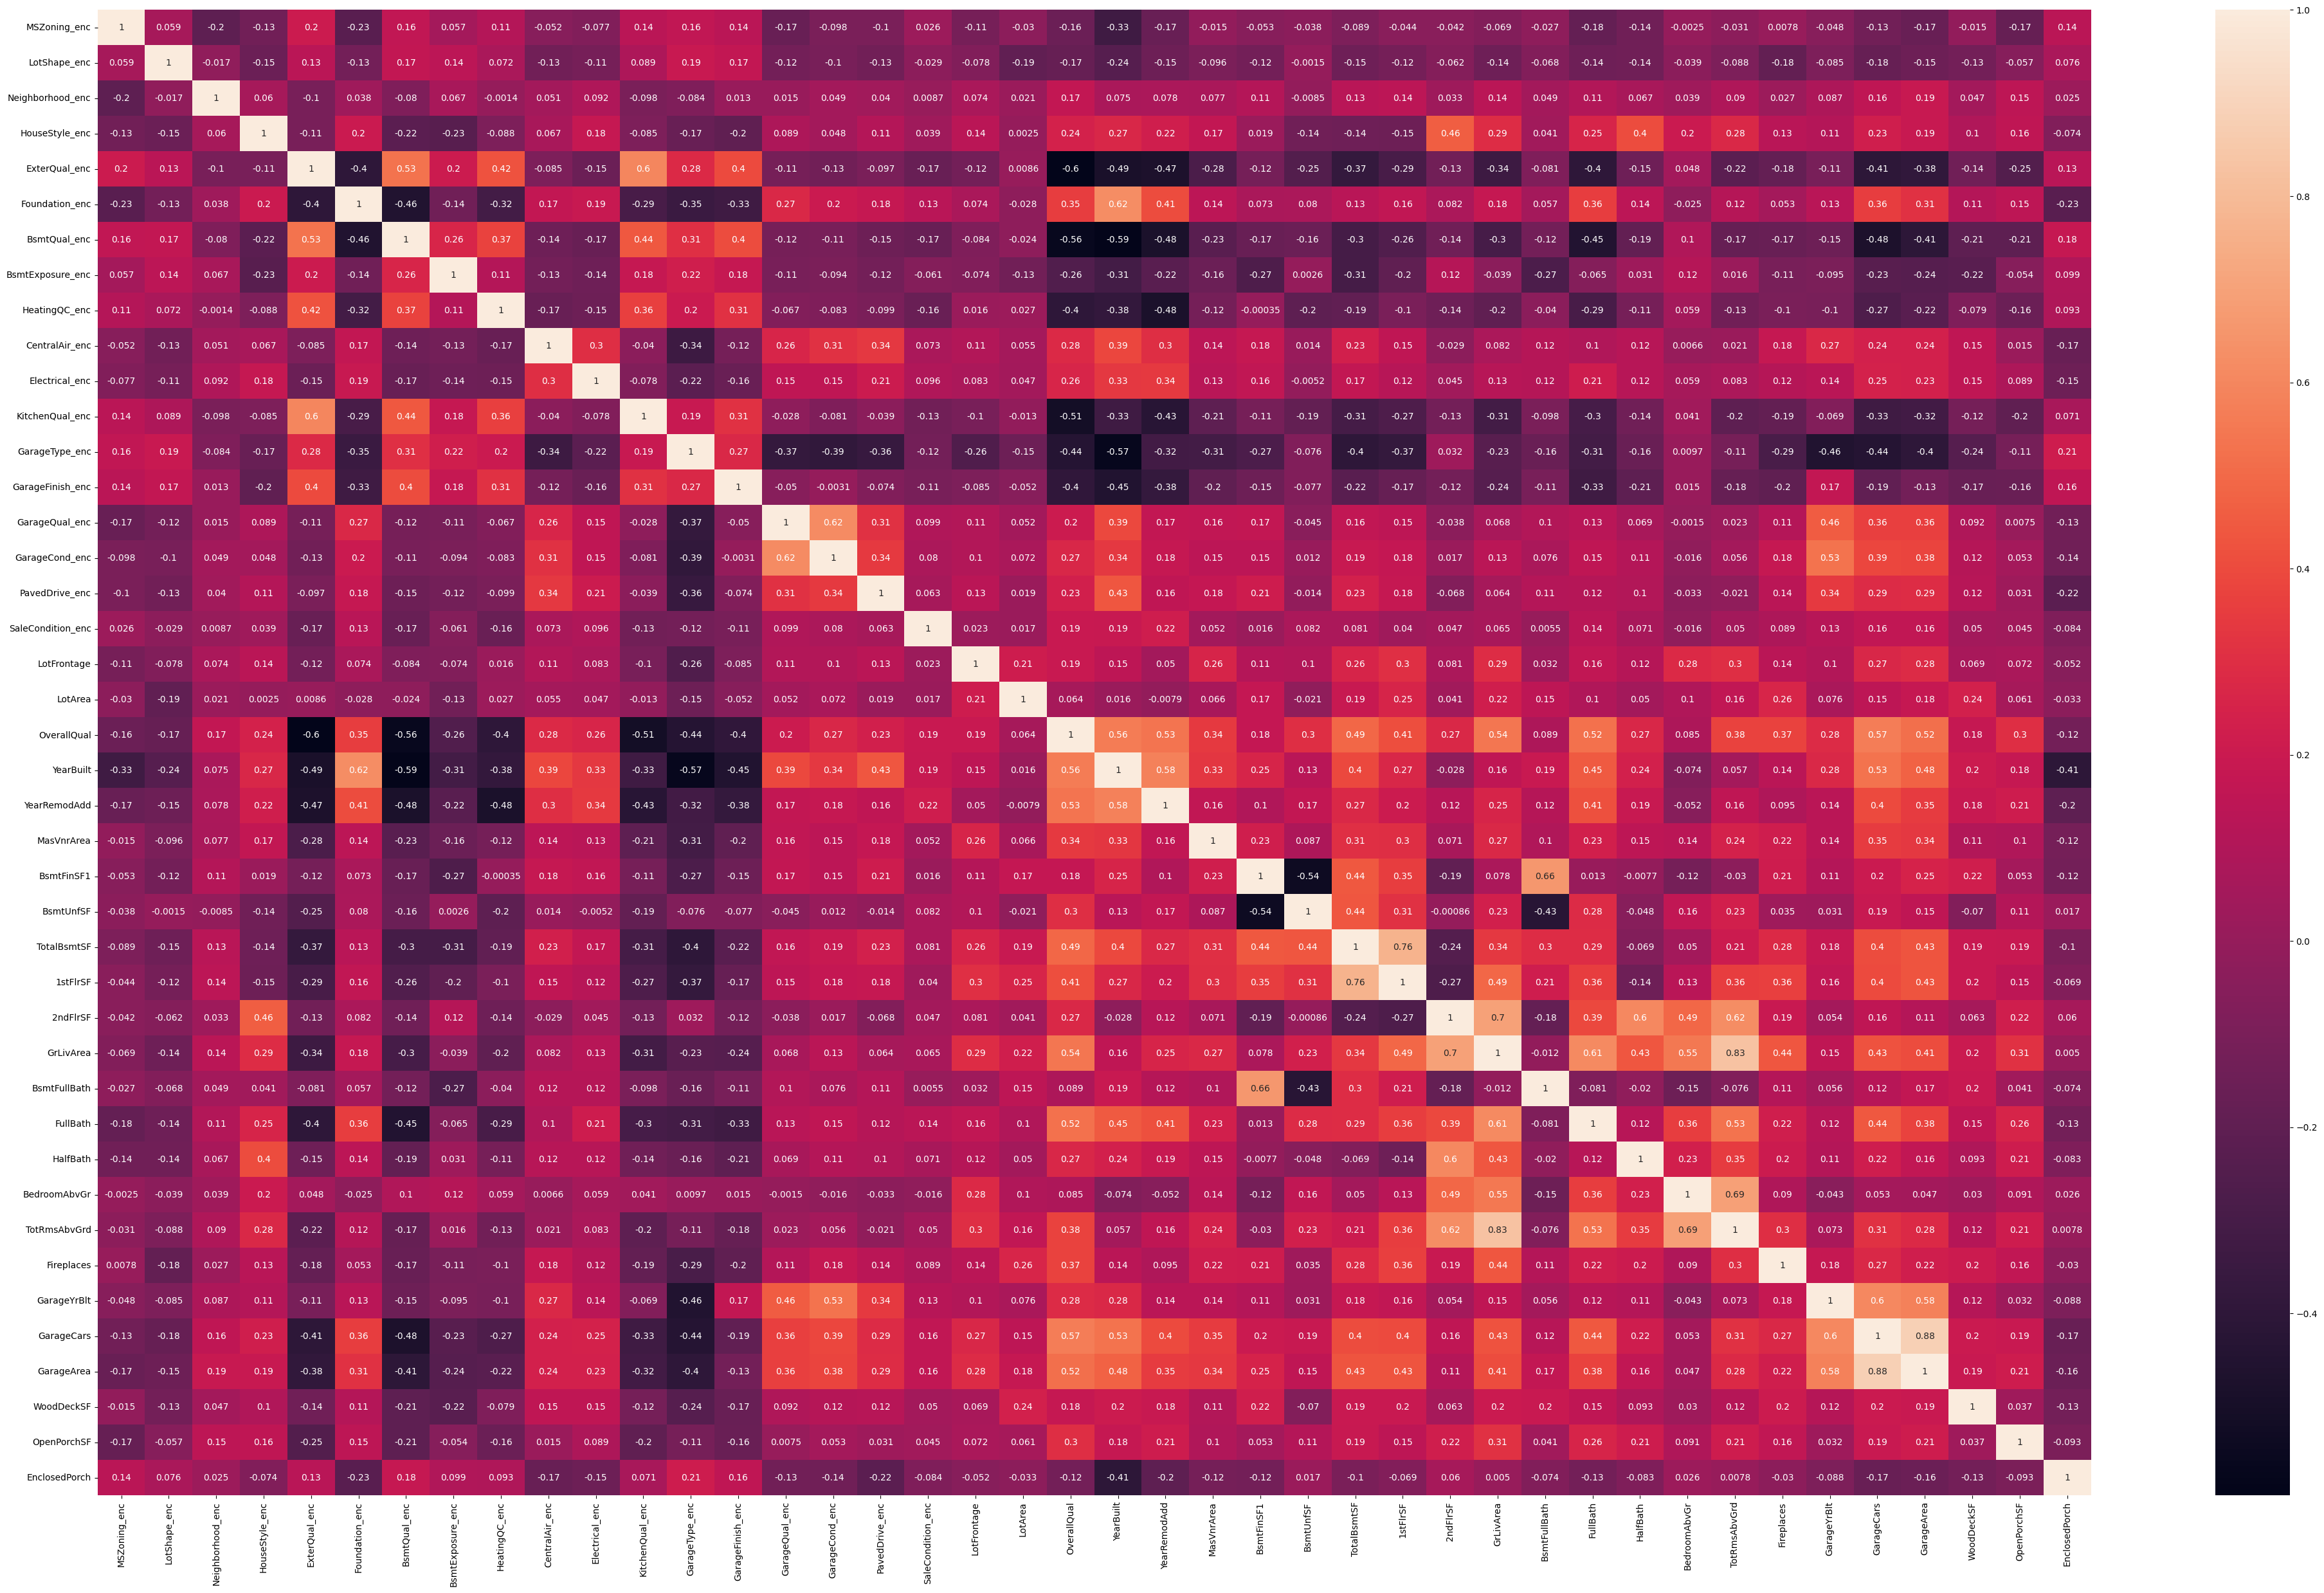

In [18]:
fig,ax = plt.subplots(1,1,figsize= (50,30))

sns.heatmap(data=corr_1_df_wo_outliers.drop(["SalePrice"],axis=1).corr(),annot=True,
            ax = ax)

Conclusion: The next paragraph shows the analytical decisions we took to reduce the number of features which may present multicollinearity. We are going to eliminate these features for further model training and testing and will compare the results with the results from the models trained with shaplee values dataset reduction.

GarageQual - GarageCond - 0.62
<br>garageQual - SalePrice - 0.21
GarageCond - SalePrice - 0.27
<br>**Keep GarageCond** <br>



LotFrontage - LotArea - .2
<br>LotFrontage - SalePrice - 0.31
LotArea - SalePrice - 0.24
<br>**Keep LotFrontage**<br>



yearbuilt - yearremodadd - 0.58<br>
yearbuilt - SalePrice - 0.55
yearremodadd - SalePrice - 0.52<br>
**Keep YearRemodAdd**




TotalBsmtSF - 1stFlrSF
<br>**Keep TotalBsmtSF**<br>



BsmtFinType1 - BsmtUnfSF  - BsmtFinSF1 - TotalBsmtSF
<br>**Keep TotalBsmtSF**<br>



GrLivArea - TotRmsAbvGrd - 0.83
<br>GrLivArea - SalePrice - 0.68
TotRmsAbvGrd - SalePrice - 0.49 
<br>**Keep GrLivArea**<br>


TotRmsAbvGrd - BedroomAbvGr - 0.69
<br>**Remove both**<br>



GarageYrBlt -  GarageCars  -  GarageArea <br>
GarageYrBlt - GarageCars - 0.6
GarageYrBlt -  GarageArea - 0.58
<br>GarageCars - GarageArea - 0.88
GarageCars - Saleprice - 0.62
GarageArea - SalePrice - 0.61
<br>**Keep GarageArea**<br>




In [19]:
corr_remove_cols = ["YearBuilt","GarageQual", "LotArea", "1stFlrSF", "BsmtFinType1", "BsmtUnfSF","BsmtFinSF1", "TotRmsAbvGrd", "GarageCars",
                     "GarageYrBlt"]


corr_1_df_wo_outliers.drop(corr_remove_cols, axis=1,inplace=True,errors='ignore')
corr_2_df_wo_outliers.drop(corr_remove_cols, axis=1,inplace=True,errors='ignore')
corr_3_df_wo_outliers.drop(corr_remove_cols, axis=1,inplace=True,errors='ignore')
corr_4_df_wo_outliers.drop(corr_remove_cols, axis=1,inplace=True,errors='ignore')

## Shapley values approach

This section involves computing the SHAP values for each feature in order to find which ones contribute the most to the **SalePrice** predictions. The strategy is to plot these values and construct 3 subset dataframes with different feature number ranges, next step will be to put them to test to find if we can improve baseline performance.

In [20]:
X_shap_df_feat_sel = df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_feat_sel= df_wo_outliers["SalePrice"]


X_train_shap,X_valid_shap,y_train_shap, y_valid_shap = train_test_split(
    X_shap_df_feat_sel.to_numpy(),y_shap_df_feat_sel.to_numpy(),test_size=test_size,random_state=random_state)


y_train_shap = y_train_shap.reshape(-1,1)
y_valid_shap = y_valid_shap.reshape(-1,1)

#Normalize train shap

scaler_X_shap = StandardScaler().fit(X_train_shap)

X_train_shap_norm = scaler_X_shap.transform(X_train_shap)
y_train_shap_norm = np.log(y_train_shap)

#normalize validation shap, mean and stddev from training distribution

mean_X_train_shap = scaler_X_shap.mean_.reshape(1,-1).repeat(X_valid_shap.shape[0],axis=0)

X_valid_shap_norm = (X_valid_shap - mean_X_train_shap) / scaler_X_shap.scale_
y_valid_shap_norm = np.log(y_valid_shap)


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


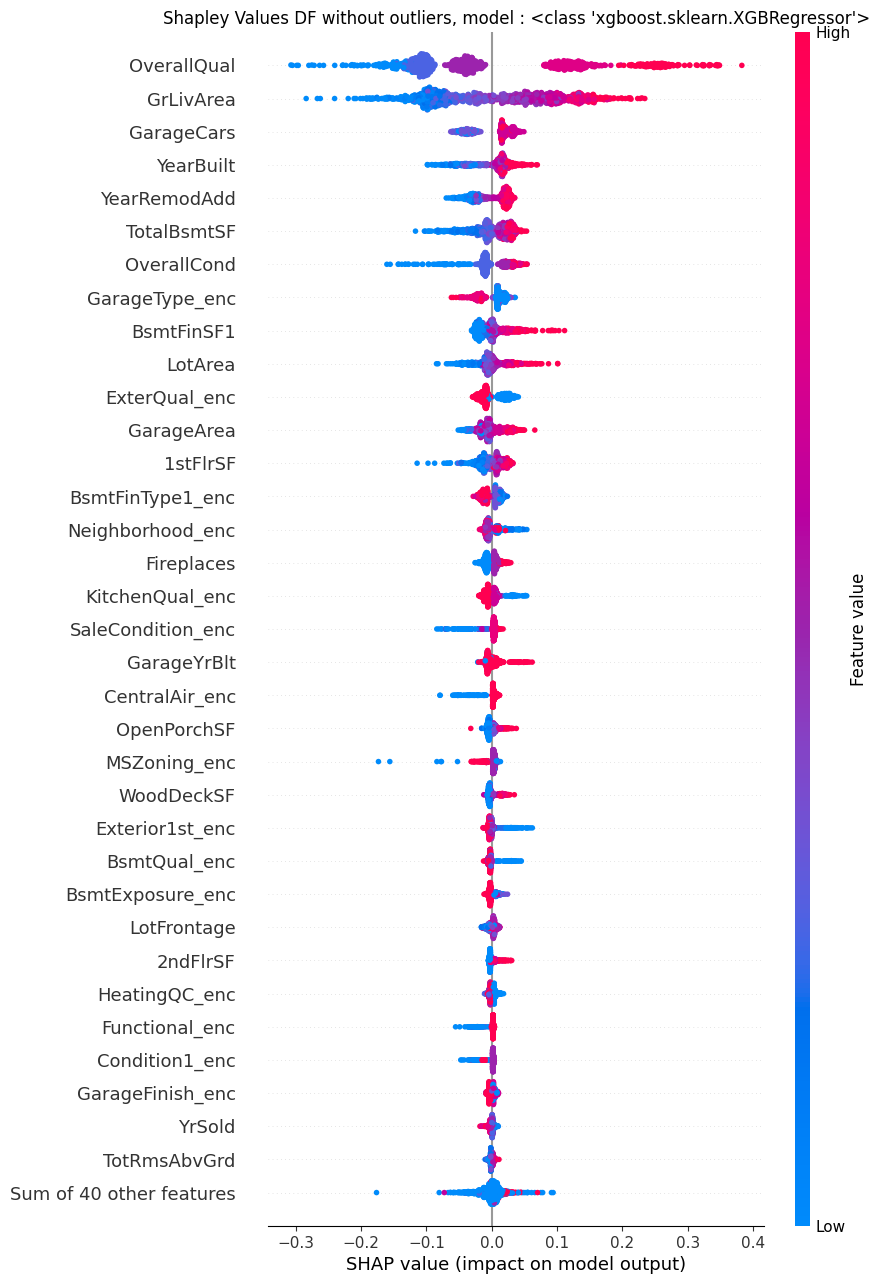

In [39]:
# Train XGBRegressor

model_shap_3 = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose)
model_shap_3.fit(X_train_shap_norm,y_train_shap_norm)
# explain the model's predictions using SHAP
explainer3 = shap.Explainer(model_shap_3,seed=random_state)


explanation3 = shap.Explanation(
    values=explainer3(X_train_shap_norm), 
    feature_names=X_shap_df_feat_sel.columns
)

shap.plots.beeswarm(explanation3,max_display=35,show=False)
plt.title(f"Shapley Values DF without outliers, model : {model_shap_3.__class__}")
plt.show()

Analysis: <br>

1. High values for **OverallQual** highly contributes on higher saleprice predictions, meanwhile lower feature values results in decreased saleprice prediction outputs.
2. High **GrLivArea** values produce higher prediction output values, contrary, lower values produce lower saleprice values.
3. In relatively lower scale, a higher value in **GarageCars** yields imcrement in SalePrices, on the other hand, lower value in this feature reduces SalePrices.
4. From the lower portion of the plot, we can infer that from features CentralAir to TotRmsAbvGrd, most of the concentration of examples lie within zero, meaning that these features do not provide a meaningful contribution to the output prediction.

Conclusion: Based on the previous Beaswarm plot and carefully analyzing the results. We are going to construct 4 dataframes with the following features:
Note: We are going to specify feature ranges and the corresponding values will be in accordance to the beaswarm plot.

1. Shapley Feature Selection 1: Features -> **OverallQual - YearRemodAdd**
2. Shapley Feature Selection 2: Features -> **OverallQual - LotArea**
3. Shapley Feature Selection 3: Features -> **OverallQual - GarageYrBlt**
3. Shapley Feature Selection 4: Features -> **OverallQual - LotFrontage**

In [59]:
shap_1_df_wo_outliers = df_wo_outliers.copy()
shap_2_df_wo_outliers = df_wo_outliers.copy()
shap_3_df_wo_outliers = df_wo_outliers.copy()
shap_4_df_wo_outliers = df_wo_outliers.copy()

shap_feat_1_names = ["OverallQual","GrLivArea","GarageCars","YearBuilt","YearRemodAdd"]
shap_1_df_wo_outliers = pd.concat([shap_1_df_wo_outliers[shap_feat_1_names], shap_1_df_wo_outliers["SalePrice"]],axis=1)

shap_feat_2_names = ["TotalBsmtSF","OverallCond","GarageType_enc","BsmtFinSF1","LotArea"]
shap_2_df_wo_outliers = pd.concat([shap_2_df_wo_outliers[shap_feat_1_names + shap_feat_2_names], shap_2_df_wo_outliers["SalePrice"]],axis=1)

shap_feat_3_names = ["ExterQual_enc","GarageArea","1stFlrSF","BsmtFinType1_enc","Neighborhood_enc", "Fireplaces", "KitchenQual_enc","SaleCondition_enc","GarageYrBlt"]
shap_3_df_wo_outliers = pd.concat([shap_3_df_wo_outliers[shap_feat_1_names + shap_feat_2_names + shap_feat_3_names], shap_3_df_wo_outliers["SalePrice"]],axis=1)


shap_feat_4_names = ["CentralAir_enc","OpenPorchSF","MSZoning_enc","WoodDeckSF","Exterior1st_enc","BsmtQual_enc","BsmtExposure_enc",
                     "LotFrontage"]
shap_4_df_wo_outliers = pd.concat([shap_4_df_wo_outliers[shap_feat_1_names + shap_feat_2_names + shap_feat_3_names +
                                                         shap_feat_4_names], shap_4_df_wo_outliers["SalePrice"]],axis=1)

## Feature Selection Dataframes Model Benchmark

In [40]:
# Dataframes processing - Correlation Feature Selection

X_corr_df_1 = corr_1_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_corr_df_1 = corr_1_df_wo_outliers["SalePrice"]
X_corr_df_2 = corr_2_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_corr_df_2 = corr_2_df_wo_outliers["SalePrice"]
X_corr_df_3 = corr_3_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_corr_df_3 = corr_3_df_wo_outliers["SalePrice"]
X_corr_df_4 = corr_4_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_corr_df_4 = corr_4_df_wo_outliers["SalePrice"]

X_train_corr_1,X_valid_corr_1,y_train_corr_1, y_valid_corr_1 = train_test_split(
    X_corr_df_1.to_numpy(),y_corr_df_1.to_numpy(),test_size=test_size,random_state=random_state)
X_train_corr_2,X_valid_corr_2,y_train_corr_2, y_valid_corr_2 = train_test_split(
    X_corr_df_2.to_numpy(),y_corr_df_2.to_numpy(),test_size=test_size,random_state=random_state)
X_train_corr_3,X_valid_corr_3,y_train_corr_3, y_valid_corr_3 = train_test_split(
    X_corr_df_3.to_numpy(),y_corr_df_3.to_numpy(),test_size=test_size,random_state=random_state)
X_train_corr_4,X_valid_corr_4,y_train_corr_4, y_valid_corr_4 = train_test_split(
    X_corr_df_4.to_numpy(),y_corr_df_4.to_numpy(),test_size=test_size,random_state=random_state)


y_train_corr_1 = y_train_corr_1.reshape(-1,1)
y_valid_corr_1 = y_valid_corr_1.reshape(-1,1)
y_train_corr_2 = y_train_corr_2.reshape(-1,1)
y_valid_corr_2 = y_valid_corr_2.reshape(-1,1)
y_train_corr_3 = y_train_corr_3.reshape(-1,1)
y_valid_corr_3 = y_valid_corr_3.reshape(-1,1)
y_train_corr_4 = y_train_corr_4.reshape(-1,1)
y_valid_corr_4 = y_valid_corr_4.reshape(-1,1)


#Normalize train corr_1 - Correlation Feature Selection

scaler_X_corr_1 = StandardScaler().fit(X_train_corr_1)

X_train_corr_1_norm = scaler_X_corr_1.transform(X_train_corr_1)
y_train_corr_1_norm = np.log(y_train_corr_1)

#normalize validation corr_1, mean and stddev from training distribution

mean_X_train_corr_1 = scaler_X_corr_1.mean_.reshape(1,-1).repeat(X_valid_corr_1.shape[0],axis=0)

X_valid_corr_1_norm = (X_valid_corr_1 - mean_X_train_corr_1) / scaler_X_corr_1.scale_
y_valid_corr_1_norm = np.log(y_valid_corr_1)

#-------------------------------------------------------------------------------------------------------------

#Normalize train corr_2 - Correlation Feature Selection

scaler_X_corr_2 = StandardScaler().fit(X_train_corr_2)

X_train_corr_2_norm = scaler_X_corr_2.transform(X_train_corr_2)
y_train_corr_2_norm = np.log(y_train_corr_2)

#normalize validation corr_2, mean and stddev from training distribution

mean_X_train_corr_2 = scaler_X_corr_2.mean_.reshape(1,-1).repeat(X_valid_corr_2.shape[0],axis=0)

X_valid_corr_2_norm = (X_valid_corr_2 - mean_X_train_corr_2) / scaler_X_corr_2.scale_
y_valid_corr_2_norm = np.log(y_valid_corr_2)



#-------------------------------------------------------------------------------------------------------------

#Normalize train corr_3 - Correlation Feature Selection

scaler_X_corr_3 = StandardScaler().fit(X_train_corr_3)

X_train_corr_3_norm = scaler_X_corr_3.transform(X_train_corr_3)
y_train_corr_3_norm = np.log(y_train_corr_3)

#normalize validation corr_3, mean and stddev from training distribution

mean_X_train_corr_3 = scaler_X_corr_3.mean_.reshape(1,-1).repeat(X_valid_corr_3.shape[0],axis=0)

X_valid_corr_3_norm = (X_valid_corr_3 - mean_X_train_corr_3) / scaler_X_corr_3.scale_
y_valid_corr_3_norm = np.log(y_valid_corr_3)


#-------------------------------------------------------------------------------------------------------------

#Normalize train corr_4 - Correlation Feature Selection

scaler_X_corr_4 = StandardScaler().fit(X_train_corr_4)

X_train_corr_4_norm = scaler_X_corr_4.transform(X_train_corr_4)
y_train_corr_4_norm = np.log(y_train_corr_4)

#normalize validation corr_4, mean and stddev from training distribution

mean_X_train_corr_4 = scaler_X_corr_4.mean_.reshape(1,-1).repeat(X_valid_corr_4.shape[0],axis=0)

X_valid_corr_4_norm = (X_valid_corr_4 - mean_X_train_corr_4) / scaler_X_corr_4.scale_
y_valid_corr_4_norm = np.log(y_valid_corr_4)


In [60]:
# Dataframes processing - Shapley Feature Selection

X_shap_df_1 = shap_1_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_1 = shap_1_df_wo_outliers["SalePrice"]
X_shap_df_2 = shap_2_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_2 = shap_2_df_wo_outliers["SalePrice"]
X_shap_df_3 = shap_3_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_3 = shap_3_df_wo_outliers["SalePrice"]
X_shap_df_4 = shap_4_df_wo_outliers.drop(["SalePrice"],axis = 1)
y_shap_df_4 = shap_4_df_wo_outliers["SalePrice"]

X_train_shap_1,X_valid_shap_1,y_train_shap_1, y_valid_shap_1 = train_test_split(
    X_shap_df_1.to_numpy(),y_shap_df_1.to_numpy(),test_size=test_size,random_state=random_state)
X_train_shap_2,X_valid_shap_2,y_train_shap_2, y_valid_shap_2 = train_test_split(
    X_shap_df_2.to_numpy(),y_shap_df_2.to_numpy(),test_size=test_size,random_state=random_state)
X_train_shap_3,X_valid_shap_3,y_train_shap_3, y_valid_shap_3 = train_test_split(
    X_shap_df_3.to_numpy(),y_shap_df_3.to_numpy(),test_size=test_size,random_state=random_state)
X_train_shap_4,X_valid_shap_4,y_train_shap_4, y_valid_shap_4 = train_test_split(
    X_shap_df_4.to_numpy(),y_shap_df_4.to_numpy(),test_size=test_size,random_state=random_state)



y_train_shap_1 = y_train_shap_1.reshape(-1,1)
y_valid_shap_1 = y_valid_shap_1.reshape(-1,1)
y_train_shap_2 = y_train_shap_2.reshape(-1,1)
y_valid_shap_2 = y_valid_shap_2.reshape(-1,1)
y_train_shap_3 = y_train_shap_3.reshape(-1,1)
y_valid_shap_3 = y_valid_shap_3.reshape(-1,1)
y_train_shap_4 = y_train_shap_4.reshape(-1,1)
y_valid_shap_4 = y_valid_shap_4.reshape(-1,1)


#Normalize train shap_1 - Shapley Feature Selection

scaler_X_shap_1 = StandardScaler().fit(X_train_shap_1)

X_train_shap_1_norm = scaler_X_shap_1.transform(X_train_shap_1)
y_train_shap_1_norm = np.log(y_train_shap_1)

#normalize validation shap_1, mean and stddev from training distribution

mean_X_train_shap_1 = scaler_X_shap_1.mean_.reshape(1,-1).repeat(X_valid_shap_1.shape[0],axis=0)

X_valid_shap_1_norm = (X_valid_shap_1 - mean_X_train_shap_1) / scaler_X_shap_1.scale_
y_valid_shap_1_norm = np.log(y_valid_shap_1)

#-------------------------------------------------------------------------------------------------------------

#Normalize train shap_2 - Shapley Feature Selection

scaler_X_shap_2 = StandardScaler().fit(X_train_shap_2)

X_train_shap_2_norm = scaler_X_shap_2.transform(X_train_shap_2)
y_train_shap_2_norm = np.log(y_train_shap_2)

#normalize validation shap_2, mean and stddev from training distribution

mean_X_train_shap_2 = scaler_X_shap_2.mean_.reshape(1,-1).repeat(X_valid_shap_2.shape[0],axis=0)

X_valid_shap_2_norm = (X_valid_shap_2 - mean_X_train_shap_2) / scaler_X_shap_2.scale_
y_valid_shap_2_norm = np.log(y_valid_shap_2)



#-------------------------------------------------------------------------------------------------------------

#Normalize train shap_3 - Shapley Feature Selection

scaler_X_shap_3 = StandardScaler().fit(X_train_shap_3)

X_train_shap_3_norm = scaler_X_shap_3.transform(X_train_shap_3)
y_train_shap_3_norm = np.log(y_train_shap_3)

#normalize validation shap_3, mean and stddev from training distribution

mean_X_train_shap_3 = scaler_X_shap_3.mean_.reshape(1,-1).repeat(X_valid_shap_3.shape[0],axis=0)

X_valid_shap_3_norm = (X_valid_shap_3 - mean_X_train_shap_3) / scaler_X_shap_3.scale_
y_valid_shap_3_norm = np.log(y_valid_shap_3)


#-------------------------------------------------------------------------------------------------------------

#Normalize train shap_4 - Shapley Feature Selection

scaler_X_shap_4 = StandardScaler().fit(X_train_shap_4)

X_train_shap_4_norm = scaler_X_shap_4.transform(X_train_shap_4)
y_train_shap_4_norm = np.log(y_train_shap_4)

#normalize validation shap_4, mean and stddev from training distribution

mean_X_train_shap_4 = scaler_X_shap_4.mean_.reshape(1,-1).repeat(X_valid_shap_4.shape[0],axis=0)

X_valid_shap_4_norm = (X_valid_shap_4 - mean_X_train_shap_4) / scaler_X_shap_4.scale_
y_valid_shap_4_norm = np.log(y_valid_shap_4)





In [47]:
#Correlation Feature Selection Model Training



models = {
    "XGB_corr_1" : [xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
                     X_train_corr_1_norm,y_train_corr_1_norm,X_valid_corr_1_norm,y_valid_corr_1_norm],
    "LGBM_corr_1" : [lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1),
                       X_train_corr_1_norm,y_train_corr_1_norm,X_valid_corr_1_norm,y_valid_corr_1_norm],
    "XGB_corr_2" : [xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
                     X_train_corr_2_norm,y_train_corr_2_norm,X_valid_corr_2_norm,y_valid_corr_2_norm],
    "LGBM_corr_2" : [lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1),
                       X_train_corr_2_norm,y_train_corr_2_norm,X_valid_corr_2_norm,y_valid_corr_2_norm],
    "XGB_corr_3" : [xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
                     X_train_corr_3_norm,y_train_corr_3_norm,X_valid_corr_3_norm,y_valid_corr_3_norm],
    "LGBM_corr_3" : [lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1),
                       X_train_corr_3_norm,y_train_corr_3_norm,X_valid_corr_3_norm,y_valid_corr_3_norm],
    "XGB_corr_4" : [xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
                     X_train_corr_4_norm,y_train_corr_4_norm,X_valid_corr_4_norm,y_valid_corr_4_norm],
    "LGBM_corr_4" : [lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1),
                       X_train_corr_4_norm,y_train_corr_4_norm,X_valid_corr_4_norm,y_valid_corr_4_norm]
}

for model_name,model_tup in models.items():
    #train model with training set
    model_tup[0].fit(model_tup[1],model_tup[2])

    #predict output using validation set
    pred = model_tup[0].predict(model_tup[3])

    #find MSE score 
    mse_score = mean_squared_error(model_tup[4],pred)
    print(f"Model : {model_name}, MSE score in validation set : {mse_score}")

c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:13:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklea

Model : XGB_corr_1, MSE score in validation set : 0.017859831478785077
Model : LGBM_corr_1, MSE score in validation set : 0.02026064348970692
Model : XGB_corr_2, MSE score in validation set : 0.022447118535101097
Model : LGBM_corr_2, MSE score in validation set : 0.023431049482539032
Model : XGB_corr_3, MSE score in validation set : 0.023939902139495175
Model : LGBM_corr_3, MSE score in validation set : 0.02458328128980255
Model : XGB_corr_4, MSE score in validation set : 0.028821797121914898
Model : LGBM_corr_4, MSE score in validation set : 0.029065401578874328


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
#Shapley Feature Selection Model Training

models = {
    "XGB_shap_1" : [xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
                     X_train_shap_1_norm,y_train_shap_1_norm,X_valid_shap_1_norm,y_valid_shap_1_norm],
    "LGBM_shap_1" : [lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1),
                       X_train_shap_1_norm,y_train_shap_1_norm,X_valid_shap_1_norm,y_valid_shap_1_norm],
    "XGB_shap_2" : [xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
                     X_train_shap_2_norm,y_train_shap_2_norm,X_valid_shap_2_norm,y_valid_shap_2_norm],
    "LGBM_shap_2" : [lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1),
                       X_train_shap_2_norm,y_train_shap_2_norm,X_valid_shap_2_norm,y_valid_shap_2_norm],
    "XGB_shap_3" : [xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
                     X_train_shap_3_norm,y_train_shap_3_norm,X_valid_shap_3_norm,y_valid_shap_3_norm],
    "LGBM_shap_3" : [lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1),
                       X_train_shap_3_norm,y_train_shap_3_norm,X_valid_shap_3_norm,y_valid_shap_3_norm],
    "XGB_shap_4" : [xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth, eta=learning_rate, subsample=0.7, colsample_bytree=0.8,
                     verbose=verbose),
                     X_train_shap_4_norm,y_train_shap_4_norm,X_valid_shap_4_norm,y_valid_shap_4_norm],
    "LGBM_shap_4" : [lgbm.LGBMRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, random_state=random_state,
                       verbose=-1),
                       X_train_shap_4_norm,y_train_shap_4_norm,X_valid_shap_4_norm,y_valid_shap_4_norm],
}

for model_name,model_tup in models.items():
    #train model with training set
    model_tup[0].fit(model_tup[1],model_tup[2])

    #predict output using validation set
    pred = model_tup[0].predict(model_tup[3])

    #find MSE score 
    mse_score = mean_squared_error(model_tup[4],pred)
    print(f"Model : {model_name}, MSE score in validation set : {mse_score}")

c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklea

Model : XGB_shap_1, MSE score in validation set : 0.02743225744483967
Model : LGBM_shap_1, MSE score in validation set : 0.026284488117454465
Model : XGB_shap_2, MSE score in validation set : 0.01748846652591051
Model : LGBM_shap_2, MSE score in validation set : 0.018111022800715654
Model : XGB_shap_3, MSE score in validation set : 0.015900640016943995
Model : LGBM_shap_3, MSE score in validation set : 0.015622802331900216
Model : XGB_shap_4, MSE score in validation set : 0.015552866619584925
Model : LGBM_shap_4, MSE score in validation set : 0.01630326082942964


c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\kevin\miniconda3\envs\hackerrank\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<table>
    <thead>
        <tr>
            <th></th>
            <th colspan = 2><center>Metric: Mean Squared Error (MSE) </center></th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td ><center>ML Model</center></td>
            <td ><center>XGBRegressor</center></td>
            <td><center>LightGBMRegressor</center></td>
        </tr>
        <tr>
            <td><center>Baseline Dataset Norm Ln(y)</center></td>
            <td><center><span style="text-decoration: underline;">0.01577</span></center></td>
            <td><center><span style="text-decoration: underline;">0.01605</span></center></td>
        </tr>
        <tr>
            <td><center>Corr Model 1</center></td>
            <td><center>0.01785</center></td>
            <td><center>0.02026</center></td>
        </tr>
        <tr>
            <td><center>Corr Model 2</center></td>
            <td><center>0.02244</center></td>
            <td><center>0.02343</center></td>
        </tr>
        <tr>
            <td><center>Corr Model 3</center></td>
            <td><center>0.02393</center></td>
            <td><center>0.02458</center></td>
        </tr>
        <tr>
            <td><center>Corr Model 4</center></td>
            <td><center>0.02882<center></td>
            <td><center>0.02906</center></td>
        </tr>
        <tr>
            <td><center>Shap Model 1</center></td>
            <td><center>0.02743</center></td>
            <td><center>0.02628</center></td>
        </tr>
        <tr>
            <td><center>Shap Model 2</center></td>
            <td><center>0.01748</center></td>
            <td><center>0.01811</center></td>
        </tr>
        <tr>
            <td><center>Shap Model 3</center></td>
            <td><center>0.0159</center></td>
            <td><center><strong>0.01562</strong></center></td>
        </tr>
        <tr>
            <td><center>Shap Model 4</center></td>
            <td><center><strong>0.015552</strong></center></td>
            <td><center>0.0163</center></td>
        </tr>
    </tbody>
</table>

Conclusion: Shapley Model 3 and 4 obtained slight improvements from baseline, thus we are going to preserver these two dataframes for the upcoming experiments. It appears that shapley values highlight feature importance capabilities is stronger than correlation analysis for this challenge.

# Saving selected Dataframes to JSON Files

In [63]:
save_path = "./data/feature-selection/"
shap_3_df_wo_outliers.to_json(save_path + "dataset-wo-outliers-shap_fs-3.json",orient="columns")
shap_4_df_wo_outliers.to_json(save_path + "dataset-wo-outliers-shap_fs-4.json",orient="columns")